In [240]:
import pandas as pd
import sys
import numpy as np
from time import time
from sklearn.svm import SVC
import plotly.express as px
sys.path.insert(1, "../")
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_auc_score, make_scorer
from src.utils import input_dataset_path
import src.preparation.process_data as p
from importlib import reload
p = reload(p)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.utils.estimator_checks import check_estimator

In [113]:
df = pd.read_csv(input_dataset_path("openstack"))
df.shape

(12374, 37)

In [117]:
df2 = p.filter_as_in_jit_moving_target(df, "openstack")
df2.shape

(12374, 37)

In [48]:
df.groupby('strata')[['author_date']].describe()

author_date                                                          \
             count          mean           std           min           25%   
strata                                                                       
0           1669.0  1.330566e+09  4.116733e+06  1.322599e+09  1.327425e+09   
1           2560.0  1.346473e+09  4.384766e+06  1.338392e+09  1.343233e+09   
2           2864.0  1.361955e+09  4.420618e+06  1.354160e+09  1.358358e+09   
3           3781.0  1.377436e+09  4.362250e+06  1.369941e+09  1.373876e+09   
4           1500.0  1.389944e+09  2.367935e+06  1.385715e+09  1.387628e+09   

                                                  
                 50%           75%           max  
strata                                            
0       1.330523e+09  1.333661e+09  1.338358e+09  
1       1.346251e+09  1.350576e+09  1.354155e+09  
2       1.361558e+09  1.365478e+09  1.369932e+09  
3       1.377094e+09  1.380879e+09  1.385704e+09  
4       1.389973e+09  1.392049e+09  1.393591e+09

In [238]:
class ClassifierWithFeatures(BaseEstimator, ClassifierMixin):
    def __init__(self, model, features, **kwargs):
        self.features = features
        self.model = model(**kwargs)
    def fit(self, X, y):
        _X = X[list(self.features)]
        self.model.fit(_X, y)
    def predict_proba(self, X):
        _X = X[list(self.features)]
        if len(self.features) == 1:
            _X = _X.values.reshape(-1, 1)
        return self.model.predict_proba(_X)
    def get_params(self, deep=True):
        params = self.model.get_params(deep)
        params['features'] = self.features
        return params

In [241]:
rf = ClassifierWithFeatures(model=SVC, features=('la', 'nf'))
rf.fit(df_train[used_columns], df_train[ycol])

/anaconda3/envs/jit-def-pred/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [239]:
rf.get_params(True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'features': ('la', 'nf')}

In [136]:
df['self'] = df['self'].astype(float)
df.fillna({"nrev": 0, "rtime": 1.1*df.rtime.min(), 'hcmt': -1, 'app': -1, 'rexp': -1, 'self': -1, 'rrexp': -1, 'rsexp': -1}, inplace=True)
df_train = df.query('strata < 4').sort_values(by='author_date')
df_test = df.query('strata >= 4').sort_values(by='author_date')

In [137]:
used_columns = ["la", "ld", "nf", "nd", "ns", "ent", "nrev", "rtime", "hcmt", "ndev", "age", "nuc", "app", "aexp", "rexp", "arexp", "rrexp", "asexp", "rsexp", "asawr", "rsawr"]
n_features = len(used_columns)
print(n_features)
ycol = "buggy"

21


In [199]:
rf.get_params().keys()

dict_keys(['features'])

In [139]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [203]:
('a',) + ('b', 'f',)

('a', 'b', 'f')

In [232]:
rf = RandomForestClassifierWithFeatures(features=(), random_state=0)
cv = TimeSeriesSplit(5)
parameters = {'criterion':['gini', 'entropy'], 
              'n_estimators': [10, 100, 500, 800],
              'max_depth':[2, 5, 7, 15, 20], 
              'min_samples_split': [2, 10, 50, 100], 
              'min_samples_leaf': [1, 10, 50, 100], 
              #'max_features':[1, 2,int(n_features ** 0.5), 7, n_features],
              'max_leaf_nodes':[None, 10, 100, 1000], 
              'min_impurity_decrease':[0.0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10],
              'features': [('la'), ('la', 'nf')]
             
        }

n_iter_search = 2
n_jobs = -1
scorer = make_scorer(roc_auc_score, needs_proba=True)

In [233]:
# run randomized search
random_search = RandomizedSearchCV(rf, param_distributions=parameters, n_iter=n_iter_search, 
                                   n_jobs=n_jobs, cv=cv, scoring=scorer, iid=False)
start = time()
random_search.fit(df_train[used_columns], df_train[ycol])
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2.00 seconds for 2 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.562 (std: 0.025)
Parameters: {'n_estimators': 10, 'min_samples_split': 100, 'min_samples_leaf': 50, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 100, 'max_depth': 5, 'features': ('la', 'nf'), 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.562 (std: 0.025)
Parameters: {'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 100, 'min_impurity_decrease': 1e-05, 'max_leaf_nodes': 10, 'max_depth': 7, 'features': ('la', 'nf'), 'criterion': 'entropy'}



/anaconda3/envs/jit-def-pred/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [148]:
rf = RandomForestClassifier(100, random_state=0, max_depth=7)
rf.fit(df_train[used_columns], df_train[ycol])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [146]:
rfb = random_search.best_estimator_

In [152]:
features_by_imp = feature_importances.index.tolist()

In [149]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = used_columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [ ]:
features_by_imp  

In [166]:
def append_and_return(l, el):
    l.append(el)
    return l.copy()

In [167]:
l = []

In [168]:
r = [append_and_return(l, f) for f in features_by_imp]

In [1]:
roc_auc_score(df_test[ycol], random_search.predict_proba(df_test[used_columns])[:,1])

NameError: name 'roc_auc_score' is not defined

In [169]:
r

[['la'],
 ['la', 'nrev'],
 ['la', 'nrev', 'nf'],
 ['la', 'nrev', 'nf', 'ent'],
 ['la', 'nrev', 'nf', 'ent', 'ld'],
 ['la', 'nrev', 'nf', 'ent', 'ld', 'rtime'],
 ['la', 'nrev', 'nf', 'ent', 'ld', 'rtime', 'hcmt'],
 ['la', 'nrev', 'nf', 'ent', 'ld', 'rtime', 'hcmt', 'nd'],
 ['la', 'nrev', 'nf', 'ent', 'ld', 'rtime', 'hcmt', 'nd', 'rsawr'],
 ['la', 'nrev', 'nf', 'ent', 'ld', 'rtime', 'hcmt', 'nd', 'rsawr', 'asawr'],
 ['la',
  'nrev',
  'nf',
  'ent',
  'ld',
  'rtime',
  'hcmt',
  'nd',
  'rsawr',
  'asawr',
  'ndev'],
 ['la',
  'nrev',
  'nf',
  'ent',
  'ld',
  'rtime',
  'hcmt',
  'nd',
  'rsawr',
  'asawr',
  'ndev',
  'rsexp'],
 ['la',
  'nrev',
  'nf',
  'ent',
  'ld',
  'rtime',
  'hcmt',
  'nd',
  'rsawr',
  'asawr',
  'ndev',
  'rsexp',
  'nuc'],
 ['la',
  'nrev',
  'nf',
  'ent',
  'ld',
  'rtime',
  'hcmt',
  'nd',
  'rsawr',
  'asawr',
  'ndev',
  'rsexp',
  'nuc',
  'rrexp'],
 ['la',
  'nrev',
  'nf',
  'ent',
  'ld',
  'rtime',
  'hcmt',
  'nd',
  'rsawr',
  'asawr',
  'ndev

In [91]:
roc_auc_score(df_test[ycol], random_search.predict_proba(df_test[used_columns])[:,1])

0.7837060568741603

In [ ]:
random_search.predict_proba(df_test[used_columns])[:1]

In [11]:
clf = RandomForestClassifier(n_estimators=100, max_depth=7,random_state=0)
clf.fit(df_train[used_columns], df_train[ycol])  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
y_pred = clf.predict_proba(df_test[used_columns])[:,1]
roc_auc_score(df_test[ycol], y_pred)

0.7713557993730408

In [30]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = used_columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [31]:
feature_importances

,importance
la,1.0


In [13]:
df.groupby('buggy').la.describe()

,count,mean,std,min,25%,50%,75%,max
buggy,,,,,,,,
False,10758.0,60.68470,185.748370,1.0,4.0,16.0,48.0,4331.0
True,1616.0,187.92698,337.169187,1.0,27.0,75.0,199.5,3472.0


In [14]:
import seaborn as sb

In [22]:
df['la_bucket'] = pd.qcut(df.la, q=10)

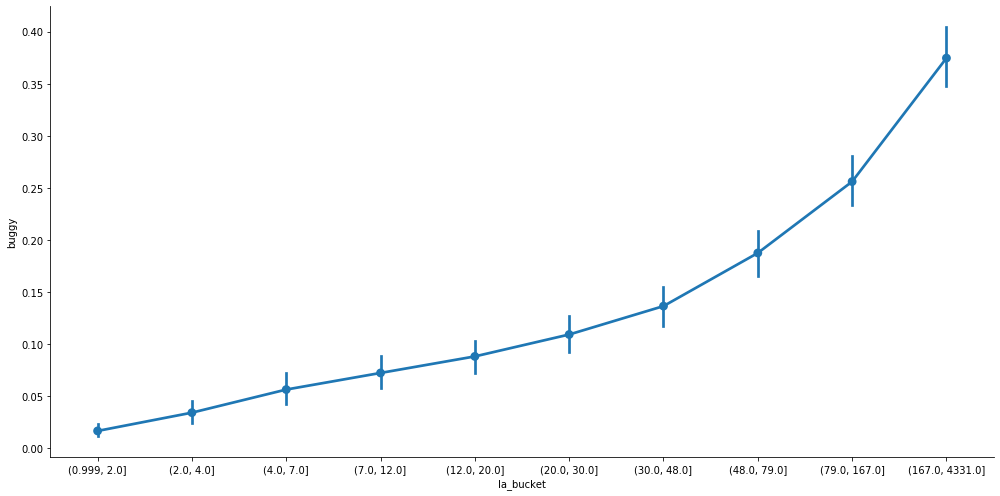

In [26]:
sb.catplot(x='la_bucket', y='buggy', data=df, kind='point', height=7, aspect=2)

In [17]:
sb.catplot(x='la_bucket', y='buggy', data=df, kind='point', height=7, aspect=2)

AttributeError: module 'plotly.express' has no attribute 'relplot'

In [32]:
def f(a: int, b: int) -> int:
    print(locals())
    return a + b


In [33]:
f(**{'a':3,'b':5,'__c':6})

TypeError: f() got an unexpected keyword argument '__c'

In [34]:
f(**{'a':3,'b':5})

{'a': 3, 'b': 5}


8